# Boosted Decision Tree to Predict Clients Behavior
#            Team Members: Liangjing Zhu, Kaidi Du, Jingxian Zhao

In [1]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import gamma
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from IPython.display import display
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
# Set the DPI (dots per inch) for our plots to be 100. 
matplotlib.rc("savefig", dpi=100)

# Set the default style for our plots to be "ggplot"
plt.style.use("ggplot")

# Set the maximum amount of data to print by default to 10 rows.
pd.set_option('display.max_rows', 10)


# Load Data, Summarize Data

In [2]:
# Loading Data
data = pd.read_csv("bank.csv", skipinitialspace=True)
data = data.dropna()

# See how may rows and columns of data we loaded.
print("The data frame's shape is...")
print(data.shape)

# The first 11 columns are input features in our following model
# The variable y is the output: if the client will subscribe a term deposit (yes: subscribe; no: not subscribe)
display(data)

The data frame's shape is...
(4521, 12)


,age,job,marital,education,default,balance,housing,loan,contact,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,3,other,no


In [3]:
# A quick statistical summary
# The mean of age is 41
print(data.describe())

               age       balance     previous
count  4521.000000   4521.000000  4521.000000
mean     41.170095   1422.657819     0.542579
std      10.576211   3009.638142     1.693562
min      19.000000  -3313.000000     0.000000
25%      33.000000     69.000000     0.000000
50%      39.000000    444.000000     0.000000
75%      49.000000   1480.000000     0.000000
max      87.000000  71188.000000    25.000000


In [4]:
# Convert some features into categories
data["job"] = data["job"].astype("category")
data["marital"] = data["marital"].astype("category")
data["education"] = data["education"].astype("category")
data["default"] = data["default"].astype("category")
data["housing"] = data["housing"].astype("category")
data["loan"] = data["loan"].astype("category")
data["contact"] = data["contact"].astype("category")
data["poutcome"] = data["poutcome"].astype("category")
data["y"] = data["y"].astype("category")
# Take a look of those data. 
# 12 different types of jobs.
print(data.describe(include=["category"]))

               job  marital  education default housing  loan   contact  \
count         4521     4521       4521    4521    4521  4521      4521   
unique          12        3          4       2       2     2         3   
top     management  married  secondary      no     yes    no  cellular   
freq           969     2797       2306    4445    2559  3830      2896   

       poutcome     y  
count      4521  4521  
unique        4     2  
top     unknown    no  
freq       3705  4000  


# Data Distribution Analytics

# Clients Age Distribution

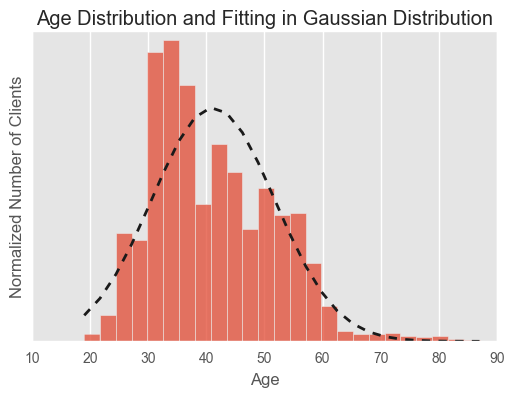

In [5]:
# The histogram of data
n, bins, patches = plt.hist(data['age'], 25, normed=1, alpha=0.75)

# Age distribution and fitting in Gaussian Function
mu = np.mean(data['age'].tolist())
variance = np.var(data['age'].tolist())
sigma = np.sqrt(variance)

# Add a fitting line
y = mlab.normpdf(bins, mu, sigma)
l = plt.plot(bins, y,"k--", linewidth=2)
plt.xlabel("Age")
plt.ylabel("Normalized Number of Clients")
plt.title("Age Distribution and Fitting in Gaussian Distribution")
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])

# Save image
plt.savefig("age_gaussian.png",bbox_inches='tight')
plt.show()


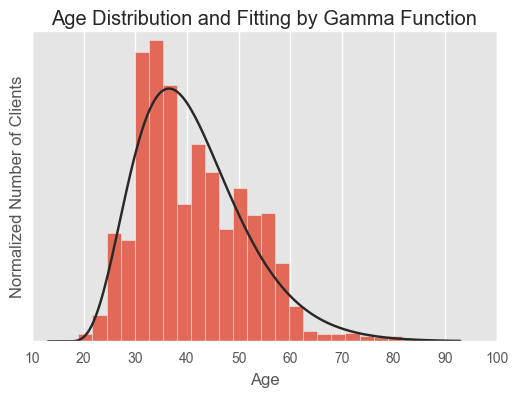

In [6]:
# Age Distribution and fitting in gamma distribution
# http://seaborn.pydata.org/tutorial/distributions.html
# Seaborn is an powerful package for visualization
sns.distplot(data['age'], kde=False, fit=stats.gamma,bins=25,hist_kws={"alpha": 0.8},kde_kws={"color": "r", "lw": 3, "label": "KDE"})
plt.xlabel("Age")
plt.ylabel("Normalized Number of Clients")
plt.title("Age Distribution and Fitting by Gamma Function")
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])

#Save image
plt.savefig("age_gamma.png",bbox_inches='tight')
plt.show()

# Clients Job Distribution

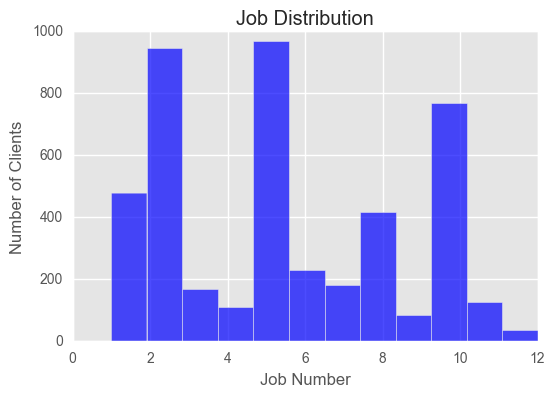

In [7]:
# Job distribution
# Set catergory to number. For example: different number for different job types
data['job']=data['job'].map({'admin.':1,'blue-collar':2,'entrepreneur':3,'housemaid':4,'management':5,'retired':6,'self-employed':7,'services':8,'student':9,'technician':10,'unemployed':11,'unknown':12})

# Plot in histogram
plt.hist(data["job"],bins=12,alpha=0.7,color='blue')
plt.xlabel("Job Number")
plt.ylabel("Number of Clients")
plt.title("Job Distribution")
ax = plt.gca()

#Save image
plt.savefig("job_distribution.png",bbox_inches='tight')
plt.show()

# Correlation Between Each Feature and the Output 

In [8]:
# Set catergory to number. For example: different number for different education types
# This step will help us in plotting and classification
# job:12; marital:4; education:4; default:2; housing:2; loan:2; contact:3; poutcome:4; y:2
# varialbe 'y' is the output: Yes or No. 
data['marital'] = data['marital'].map({ 'divorced':1,'married':2,'single':3,'unknown':4})
data['education'] = data['education'].map({'primary':1,'secondary':2,'tertiary':3,'unknown':4})
data['default'] = data['default'].map({'yes': 1, 'no': 0})
data['housing'] = data['housing'].map({'yes': 1, 'no': 0})
data['loan'] = data['loan'].map({'yes': 1, 'no': 0})
data['contact'] = data['contact'].map({ 'cellular':1,'telephone':2,'unknown':3})
data['poutcome'] = data['poutcome'].map({'failure':1,'success':2,'unknown':3,'other':4})
data['y'] = data['y'].map({'yes': 1, 'no': 0})
display(data)

,age,job,marital,education,default,balance,housing,loan,contact,previous,poutcome,y
0,30,11,2,1,0,1787,0,0,1,0,3,0
1,33,8,2,2,0,4789,1,1,1,4,1,0
2,35,5,3,3,0,1350,1,0,1,1,1,0
3,30,5,2,3,0,1476,1,1,3,0,3,0
4,59,2,2,2,0,0,1,0,3,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,8,2,2,0,-333,1,0,1,0,3,0
4517,57,7,2,3,1,-3313,1,1,3,0,3,0
4518,57,10,2,2,0,295,0,0,1,0,3,0
4519,28,2,2,2,0,1137,0,0,1,3,4,0


In [9]:
# Select the data of clients subscribe and do not subscribe 
rows_yes = data["y"] == 1
rows_no = data['y'] == 0

# Data with output "yes": Subscribe
data_yes = data[rows_yes]

# Data with output "no": Not Subscribe
data_no = data[rows_no]

# Feature "Age"

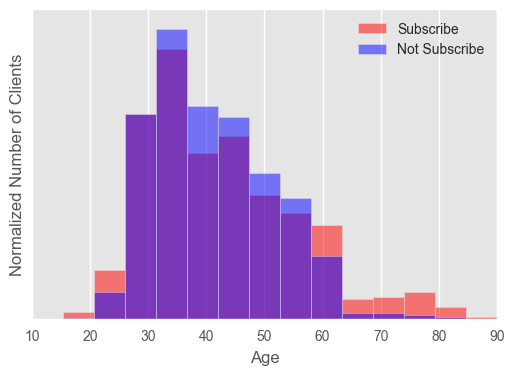

In [10]:
# Plot the normalized clients number who subscribe and do not subscribe of different age
plt.hist(data_yes["age"],bins=15,alpha=0.5,color='red',normed=True,range=(10,90),label='Subscribe')
plt.hist(data_no['age'],bins=15,alpha=0.5,color='blue',normed=True,range=(10,90),label='Not Subscribe')
plt.xlabel("Age")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("age.png",bbox_inches='tight')
plt.show()

# Feature "Job"

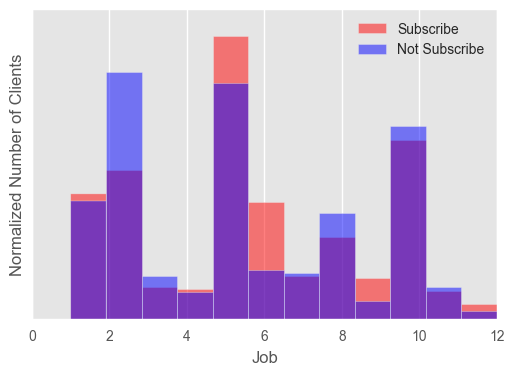

In [11]:
# Plot the normalized clients number who subscribe and do not subscribe of different jobs
plt.hist(data_yes["job"],bins=12,alpha=0.5,color='red',normed=1,align='mid',label='Subscribe')
plt.hist(data_no['job'],bins=12,alpha=0.5,color='blue',normed=1,align='mid',label='Not Subscribe')
plt.xlabel("Job")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("job.png",bbox_inches='tight')
plt.show()

# Feature "Education"

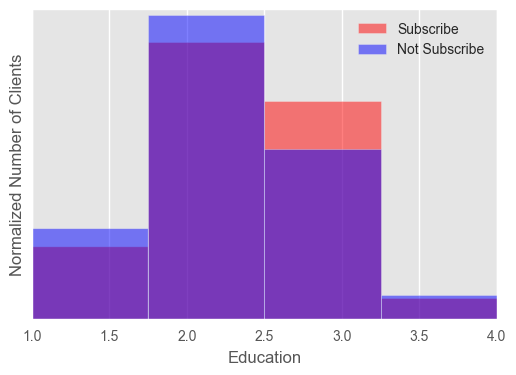

In [12]:
# Plot the normalized clients number who subscribe and do not subscribe of different educations
plt.hist(data_yes["education"],bins=4,alpha=0.5,color='red',normed=1,align='mid',label='Subscribe')
plt.hist(data_no['education'],bins=4,alpha=0.5,color='blue',normed=1,align='mid',label='Not Subscribe')
plt.xlabel("Education")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("education.png",bbox_inches='tight')
plt.show()

# Feature "Default"

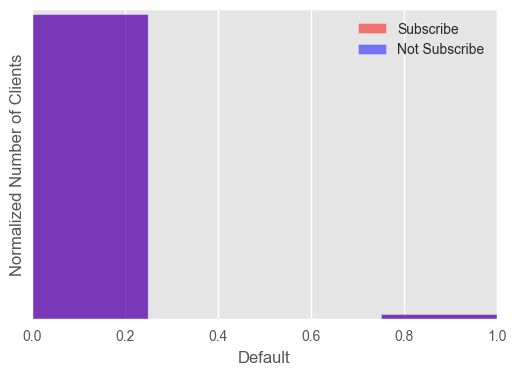

In [13]:
# Plot the normalized clients number who subscribe and do not subscribe of different default
plt.hist(data_yes["default"],bins=4,alpha=0.5,color='red',normed=1,align='mid',label='Subscribe')
plt.hist(data_no['default'],bins=4,alpha=0.5,color='blue',normed=1,align='mid',label='Not Subscribe')
plt.xlabel("Default")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("default.png",bbox_inches='tight')
plt.show()

# Feature "Marital"

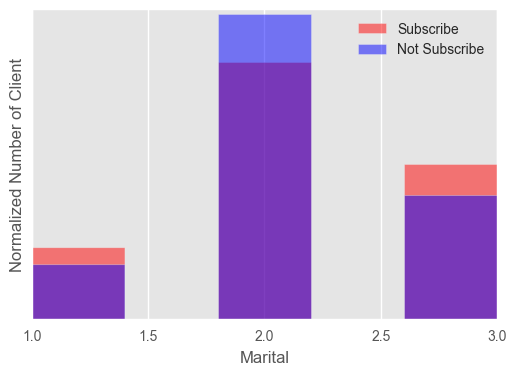

In [14]:
# Plot the normalized clients number who subscribe and do not subscribe of different marital
plt.hist(data_yes["marital"],bins=5,alpha=0.5,color='red',normed=1,align='mid',label='Subscribe')
plt.hist(data_no['marital'],bins=5,alpha=0.5,color='blue',normed=1,align='mid',label='Not Subscribe')
plt.xlabel("Marital")
plt.ylabel("Normalized Number of Client")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("marital.png",bbox_inches='tight')
plt.show()

# Feature "Balance"

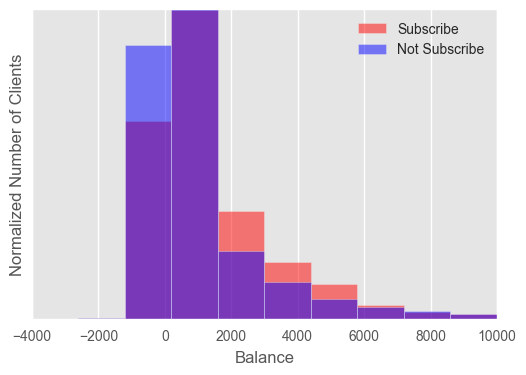

In [15]:
# Plot the normalized clients number who subscribe and do not subscribe of different balance
plt.hist(data_yes["balance"],bins=10,alpha=0.5,color='red',normed=1,range=(-4000,10000),label='Subscribe')
plt.hist(data_no['balance'],bins=10,alpha=0.5,color='blue',normed=1,range=(-4000,10000),label='Not Subscribe')
plt.xlabel("Balance")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("balance.png",bbox_inches='tight')
plt.show()

# Feature "Housing"

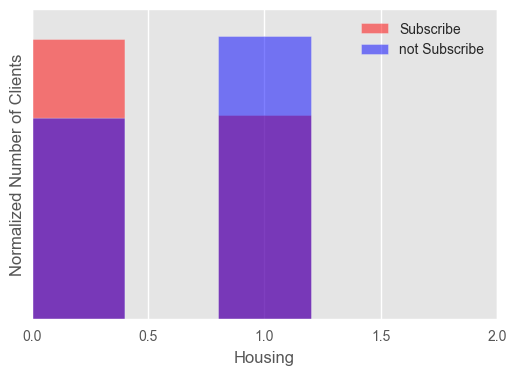

In [16]:
# Plot the normalized clients number who subscribe and do not subscribe of different housing
plt.hist(data_yes["housing"],bins=5,alpha=0.5,color='red',normed=1,align='mid',range=(0,2),label='Subscribe')
plt.hist(data_no['housing'],bins=5,alpha=0.5,color='blue',normed=1,align='mid',range=(0,2),label='not Subscribe')
plt.xlabel("Housing")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("housing.png",bbox_inches='tight')
plt.show()

# Feature "Loan"

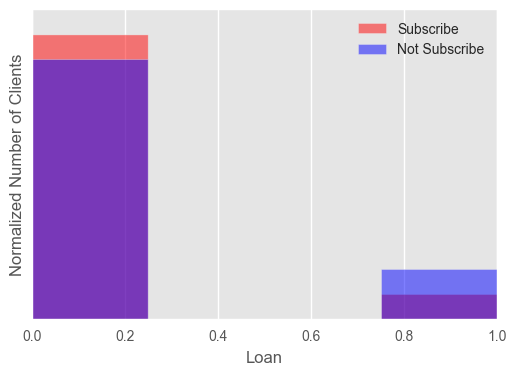

In [17]:
# Plot the normalized clients number who subscribe and do not subscribe of different loan
plt.hist(data_yes["loan"],bins=4,alpha=0.5,color='red',normed=1,align='mid',label='Subscribe')
plt.hist(data_no['loan'],bins=4,alpha=0.5,color='blue',normed=1,align='mid',label='Not Subscribe')
plt.xlabel("Loan")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("loan.png",bbox_inches='tight')
plt.show()

# Feature "Contact"

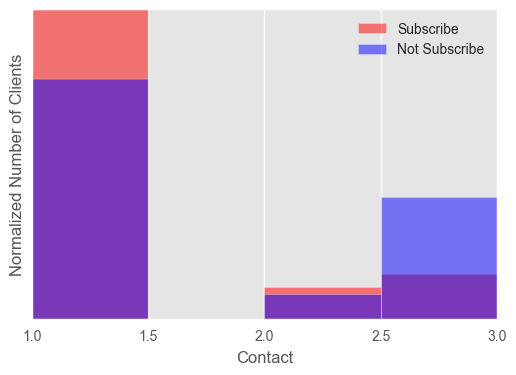

In [18]:
# Plot the normalized clients number who subscribe and do not subscribe of different contact 
plt.hist(data_yes["contact"],bins=4,alpha=0.5,color='red',normed=1,align='mid',label='Subscribe')
plt.hist(data_no['contact'],bins=4,alpha=0.5,color='blue',normed=1,align='mid',label='Not Subscribe')
plt.xlabel("Contact")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("contact.png",bbox_inches='tight')
plt.show()

# Feature "Poutcome"

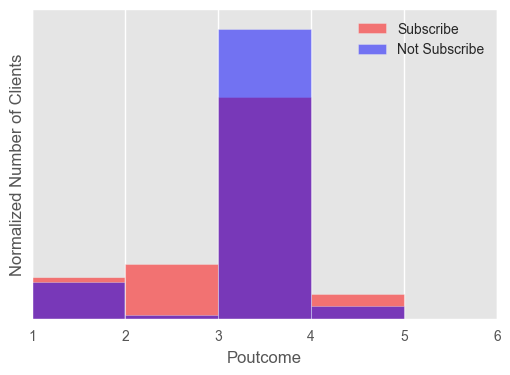

In [19]:
# Plot the normalized clients number who subscribe and do not subscribe of different previous 
plt.hist(data_yes["poutcome"],bins=5,alpha=0.5,color='red',normed=1,align='mid',range=(1,6),label='Subscribe')
plt.hist(data_no['poutcome'],bins=5,alpha=0.5,color='blue',normed=1,align='mid',range=(1,6),label='Not Subscribe')
plt.xlabel("Poutcome")
plt.ylabel("Normalized Number of Clients")
plt.legend()
ax = plt.gca()
ax.axes.get_yaxis().set_ticks([])
plt.savefig("poutcome.png",bbox_inches='tight')
plt.show()

# Correlations

In [20]:
# Correlation between different elements
data.corr()

,age,job,marital,education,default,balance,housing,loan,contact,previous,poutcome,y
age,1.000000,-0.021500,-0.381485,-0.121613,-0.017885,0.083820,-0.193888,-0.011250,0.015161,-0.003511,-0.031284,0.045092
job,-0.021500,1.000000,0.069390,0.170160,0.008324,0.009797,-0.128353,-0.040245,-0.074068,0.005029,0.005282,0.027401
marital,-0.381485,0.069390,1.000000,0.102714,-0.020745,0.024971,-0.029851,-0.045210,-0.068236,0.038028,-0.015824,0.015042
education,-0.121613,0.170160,0.102714,1.000000,-0.010534,0.057725,-0.087070,-0.054086,-0.110554,0.023983,-0.020363,0.042987
default,-0.017885,0.008324,-0.020745,-0.010534,1.000000,-0.070886,0.006881,0.063994,0.008448,-0.026656,0.043730,0.001303
...,...,...,...,...,...,...,...,...,...,...,...,...
loan,-0.011250,-0.040245,-0.045210,-0.054086,0.063994,-0.071349,0.018451,1.000000,-0.007319,-0.022115,0.017482,-0.070517
contact,0.015161,-0.074068,-0.068236,-0.110554,0.008448,-0.009665,0.196454,-0.007319,1.000000,-0.187232,0.185293,-0.133595
previous,-0.003511,0.005029,0.038028,0.023983,-0.026656,0.026196,0.038621,-0.022115,-0.187232,1.000000,-0.387180,0.116714
poutcome,-0.031284,0.005282,-0.015824,-0.020363,0.043730,-0.030737,-0.050256,0.017482,0.185293,-0.387180,1.000000,-0.066949


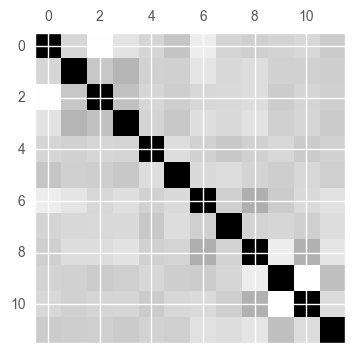

In [21]:
# Plot the correlation, dark color means more correlation
plt.matshow(data.corr())

# Boosted Decision Tree Model Building

In [22]:
# Model Building Process by Boosted Decision Tree
# Use package AdaBoostClssfier
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_multiclass.html
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# From DataFrame to numpy Matrix
# Build Matrix for clustering
dataMatrix = data.as_matrix()

# Function to build the input features and output
def BuildXYPair(inputData):
    # Features: Age, Job, Marital ....
    x = inputData[:,:-1]
    # Output: Subscribe(Yes or No)
    y = inputData[:,-1]
    return(x,y)

# Function to build model
# Also split training and testing data
def TrainData(inputData):
    
    # 70% Data for training, 30% Data for testing
    frac_split = 0.7
    
    # Shuffle data
    np.random.shuffle(inputData)
    
    # Split data
    split_index = int(inputData.shape[0]*frac_split)
    inputData_train = inputData[0:split_index, :]
    inputData_test = inputData[split_index:, :]
    
    # Convert to X,Y pair
    X_train, Y_train = BuildXYPair(inputData_train)
    X_test, Y_test = BuildXYPair(inputData_test)
    
    # Build classifier
    bdt = AdaBoostClassifier(
                              DecisionTreeClassifier(max_depth=3),
                              n_estimators=800,
                              learning_rate=1.,
                            )
    print("Training BDT ... ")
    bdt.fit(X_train, Y_train)
    print("Our BDT model is finished!")
    return (bdt, inputData_test)

# Function to Test Data
def TestModel(model, TestData):
    X_test, Y_test = BuildXYPair(TestData)
    print("Testing for accracy ...")
    
    # The accuracy of the model
    print("The Accuracy is :%f" % model.score(X_test, Y_test))
    return

# BDT is the model we build
BDT, TestData = TrainData(dataMatrix)

# Show the accuracy of BDT model
TestModel(BDT,TestData)

# Show the relative importance of each feature
importance=BDT.feature_importances_
print(importance)

Training BDT ... 
Our BDT model is finished!
Testing for accracy ...
The Accuracy is :0.854827
[  2.02870916e-01   9.46184465e-02   4.52683765e-02   4.24550237e-02
   3.46282066e-04   4.70569574e-01   3.48466569e-02   1.25962702e-02
   2.94132746e-02   3.81775318e-02   2.88376472e-02]


# Client Behavior Prediction

In [23]:
# BDT model can be used to predict the client behavior
# Use function: model.predict

#         age    job      marital education default balance housing loan  contact   previous poutcome
# Client1 30  unemployed  married primary    no      1787    no     no    cellular   0       unknown
# Client2 49  technician  married tertiary   no      1235    no     no    cellular   0       unknown

# Convert feature into number
client1=[30,11,2,1,0,1787,0,0,1,0,3]
client2=[49,10,2,3,0,1235,0,0,1,0,3]

# Predict client behavior: 0 for no; 1 for yes
print(BDT.predict(client1))
print(BDT.predict(client2))

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[0]
[1]


# Relative Importance of Each Feature

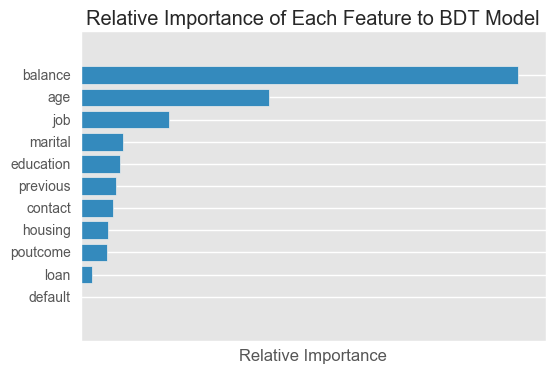

In [24]:
# Plot the importance of each features

# Sorted the importance from small to big
importance_order=sorted(importance)

# Find the corresponding feature from above
objects = ('default','loan','poutcome','housing','contact','previous','education','marital','job','age','balance')

# Plot the relative importance in order
y_pos = np.arange(len(objects)) 
plt.barh(y_pos,importance_order, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('Relative Importance')
plt.title('Relative Importance of Each Feature to BDT Model')
ax = plt.gca()
ax.axes.get_xaxis().set_ticks([])
plt.savefig("Relative_importance.png",bbox_inches='tight')
plt.show()